<a href="https://colab.research.google.com/github/Chubbyman2/Detectron2/blob/main/suits_detectron2_custom_coco_data_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Detectron2 demo with a custom dataset labelled using LabelMe. 

Dataset consists of pictures of the main cast from the TV show Suits, with their heads labelled as instances.

# Install Pytorch and Detectron2

In [ ]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 251kB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-4tib28b5
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-4tib28b5
     |████████████████████████████████| 645kB 15.4MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3-cp37-none-any.whl size=56344 sha256=86b9100f25b7f93508d0e582e9dc4148762067daee58d34a3df6d26f99cf58a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-mzvd2bjr/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel for iopath: filename=iopath-0.1.4-cp37-none-any.whl size=15

'1.7.1'

In [ ]:
# Restart runtime after this, as instructed
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 10335 (delta 3), reused 6 (delta 3), pack-reused 10300
Receiving objects: 100% (10335/10335), 4.32 MiB | 26.50 MiB/s, done.
Resolving deltas: 100% (7431/7431), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 2.2MB 18.0MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0
  Running setup.py develop for detectron2


In [ ]:
# Make sure Cuda ver is same for detectron2 and colab
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
!python -m detectron2.utils.collect_env

----------------------  ---------------------------------------------------------
sys.platform            linux
Python                  3.7.10 (default, Feb 20 2021, 21:17:23) [GCC 7.5.0]
numpy                   1.19.5
detectron2              0.3 @/content/detectron2_repo/detectron2
Compiler                GCC 7.5
CUDA compiler           CUDA 10.1
detectron2 arch flags   7.5
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.7.1 @/usr/local/lib/python3.7/dist-packages/torch
PyTorch debug build     False
GPU available           True
GPU 0                   Tesla T4 (arch=7.5)
CUDA_HOME               /usr/local/cuda
Pillow                  8.1.0
torchvision             0.8.2 @/usr/local/lib/python3.7/dist-packages/torchvision
torchvision arch flags  3.5, 5.0, 6.0, 7.0, 7.5
fvcore                  0.1.3
cv2                     4.1.2
----------------------  ---------------------------------------------------------
PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R

In [ ]:
# Setup Detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Training on Custom Suits Dataset

In [ ]:
# Load data from drive
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

!unzip "/content/drive/My Drive/suits.zip"

Mounted at /content/drive/
Archive:  /content/drive/My Drive/suits.zip
   creating: suits/images/
  inflating: suits/images/suits_1.jpg  
  inflating: suits/images/suits_10.jpg  
  inflating: suits/images/suits_11.jpg  
  inflating: suits/images/suits_12.jpg  
  inflating: suits/images/suits_13.jpg  
  inflating: suits/images/suits_14.jpg  
  inflating: suits/images/suits_15.png  
  inflating: suits/images/suits_16.jpg  
  inflating: suits/images/suits_17.png  
  inflating: suits/images/suits_18.jpg  
  inflating: suits/images/suits_19.jpg  
  inflating: suits/images/suits_2.jpg  
  inflating: suits/images/suits_20.jpg  
  inflating: suits/images/suits_3.jpg  
  inflating: suits/images/suits_4.jpg  
  inflating: suits/images/suits_5.jpg  
  inflating: suits/images/suits_6.jpg  
  inflating: suits/images/suits_7.jpg  
  inflating: suits/images/suits_8.jpg  
  inflating: suits/images/suits_9.png  
  inflating: suits/suits_1.json      
  inflating: suits/suits_10.json     
  inflating: su

In [ ]:
# Register Coco dataset
from detectron2.data.datasets import register_coco_instances
register_coco_instances("suits", {}, "./suits/trainval.json", "./suits/images")

In [ ]:
suits_metadata = MetadataCatalog.get("suits")
dataset_dicts = DatasetCatalog.get("suits")

WARNING [02/24 17:38:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/24 17:38:35 d2.data.datasets.coco]: Loaded 20 images in COCO format from ./suits/trainval.json


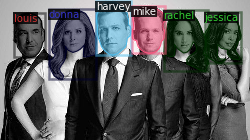

In [ ]:
# Display a random sample of the labelled data
import random

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=suits_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Fine-Tune Coco-Pretrained R50-FPN Mask R-CNN model on Suits dataset.


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("suits")
cfg.DATASETS.TEST = ()   # No metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 300    # Train for longer if you wish
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # Good enough for a basic dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # 6 classes (Harvey, Donna, Mike, Rachel, Louis, Jessica)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/24 17:38:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:07, 24.6MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to

[02/24 17:38:57 d2.engine.train_loop]: Starting training from iteration 0


/content/detectron2_repo/detectron2/structures/masks.py:348: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/content/detectron2_repo/detectron2/structures/masks.py:348: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/content/detectron2_repo/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg

[02/24 17:39:01 d2.utils.events]:  eta: 0:01:03  iter: 19  total_loss: 2.579  loss_cls: 1.343  loss_box_reg: 0.3471  loss_mask: 0.6794  loss_rpn_cls: 0.1179  loss_rpn_loc: 0.01896  time: 0.2311  data_time: 0.0113  lr: 0.00039962  max_mem: 1603M
[02/24 17:39:06 d2.utils.events]:  eta: 0:00:58  iter: 39  total_loss: 2.22  loss_cls: 0.687  loss_box_reg: 0.9098  loss_mask: 0.5595  loss_rpn_cls: 0.0201  loss_rpn_loc: 0.01394  time: 0.2313  data_time: 0.0024  lr: 0.00079922  max_mem: 1603M
[02/24 17:39:11 d2.utils.events]:  eta: 0:00:55  iter: 59  total_loss: 1.942  loss_cls: 0.608  loss_box_reg: 0.8573  loss_mask: 0.4379  loss_rpn_cls: 0.01494  loss_rpn_loc: 0.01521  time: 0.2354  data_time: 0.0024  lr: 0.0011988  max_mem: 1603M
[02/24 17:39:16 d2.utils.events]:  eta: 0:00:51  iter: 79  total_loss: 1.665  loss_cls: 0.5603  loss_box_reg: 0.7125  loss_mask: 0.3277  loss_rpn_cls: 0.003187  loss_rpn_loc: 0.01697  time: 0.2369  data_time: 0.0023  lr: 0.0015984  max_mem: 1603M
[02/24 17:39:21 d2.

In [ ]:
# Create predictor using trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("suits", )
predictor = DefaultPredictor(cfg)

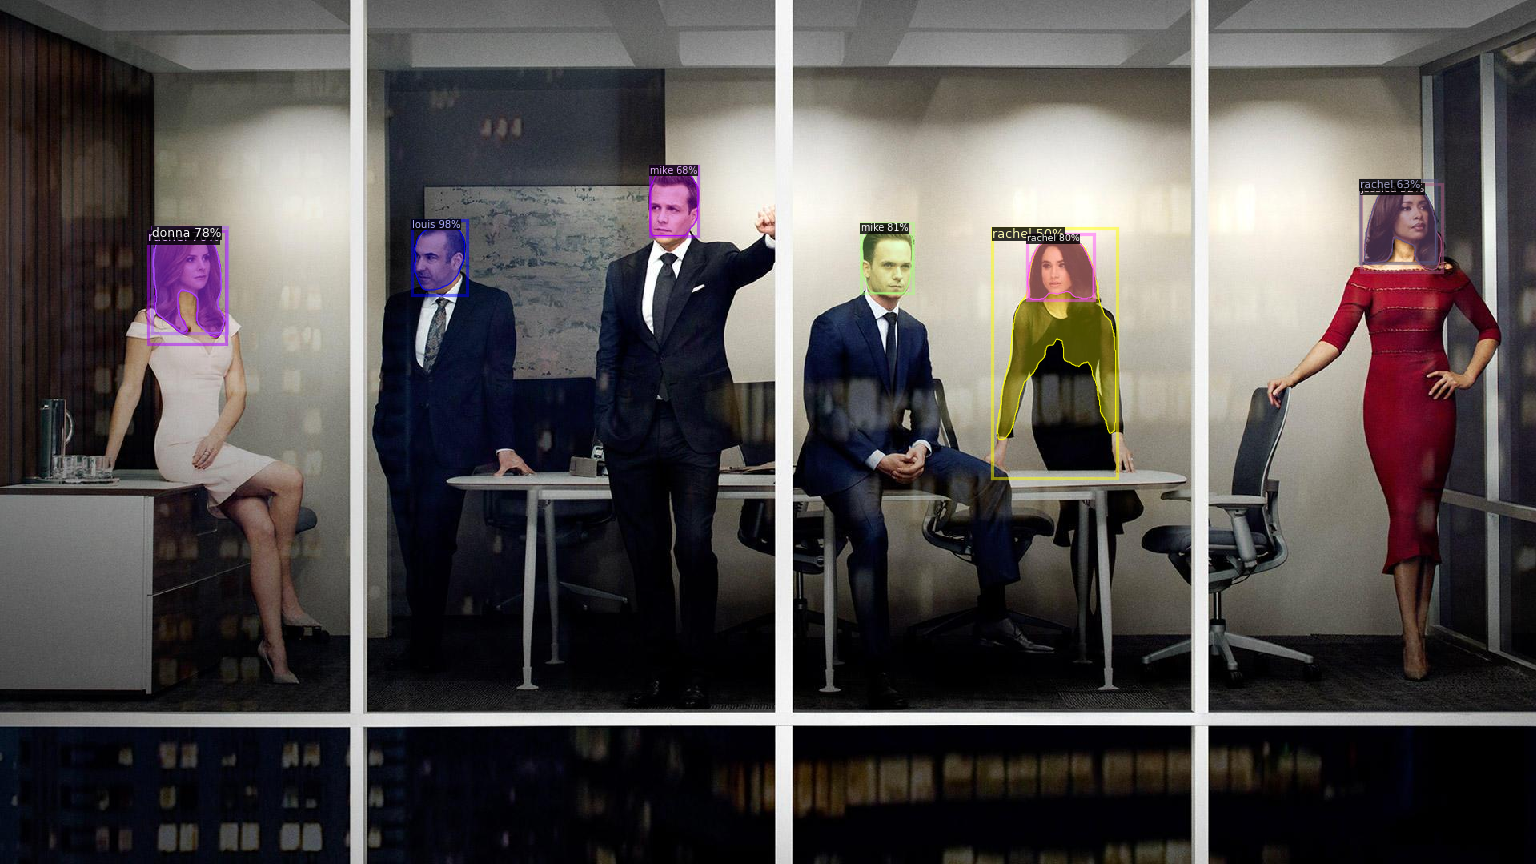

In [ ]:
# Select randomly from sample data to visualize predictions
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=suits_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
suits_metadata

Metadata(evaluator_type='coco', image_root='./suits/images', json_file='./suits/trainval.json', name='suits', thing_classes=['donna', 'harvey', 'jessica', 'louis', 'mike', 'rachel'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5})

# Inference Speed

In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec): {:.2f}, FPS: {:.2f}".format(mean_delta, fps))